## Demonstrative Applications of the Nlarc Optimizer

In [1]:
import os
# Set TensorFlow environment variables to suppress logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Only show errors
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'  # Further suppression of verbose logs
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async' # Configure TensorFlow GPU allocator

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
)

from tensorflow.keras.datasets import cifar10, mnist, cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, VGG19, ConvNeXtBase
from src.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Set floatx to float32
tf.keras.backend.set_floatx('float64')

## An MLP model on MNIST dataset

In [4]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to [0, 1] range
train_images = train_images.astype('float64') / 255
test_images = test_images.astype('float64') / 255

# Flatten the images
train_images = train_images.reshape((train_images.shape[0], 28 * 28))
test_images = test_images.reshape((test_images.shape[0], 28 * 28))

# Convert labels to one-hot encoded format
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Create the MLP model
model = models.Sequential([
    layers.Dense(1000, activation='relu', input_shape=(28 * 28,)),
    layers.Dense(1000, activation='relu'),
    # layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0)]

# Initialize the Nlarc optimizer with the desired hyperparameters
optimizer = Nlarc() # learning_rate=0.1, momentum=1, global_clipnorm=None, sigma=1e-19, k0=1

# Compile the model
model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=300, validation_split=0, verbose=1)

# Evaluate the model on test data
_, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/20
200/200 [==============================] - 4s 10ms/step - loss: 0.2843 - accuracy: 0.9159
Epoch 2/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0894 - accuracy: 0.9734
Epoch 3/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0564 - accuracy: 0.9834
Epoch 4/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0378 - accuracy: 0.9895
Epoch 5/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0261 - accuracy: 0.9930
Epoch 6/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0188 - accuracy: 0.9954
Epoch 7/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0131 - accuracy: 0.9972
Epoch 8/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0093 - accuracy: 0.9983
Epoch 9/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0065 - accuracy: 0.9992
Epoch 10/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0051 - accuracy: 0.999

## VGG16 on CIFAR-10 dataset

In [25]:
# Load and preprocess data

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float64') / 255
x_test = x_test.astype('float64') / 255

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 10).astype('float64')
y_test = to_categorical(y_test, 10).astype('float64')

metrics=['accuracy']
acc_nlarc = []

input_shape = (32, 32, 3)
num_classes = 10
n_runs = 5

for run in range(n_runs):
    # Load VGG16 model, pre-trained on ImageNet without the top layer (classifier)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of VGG16 model
    for layer in base_model.layers:
        layer.trainable = False

    # Assuming `base_model` is the original VGG16 loaded without top
    model = Sequential()
    for layer in base_model.layers:
        model.add(layer)
        if 'conv' in layer.name:
            model.add(BatchNormalization())  # Add batch normalization after each conv layer

    # Continue building the rest of your model
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  

    # Initialize the Nlarc optimizer with the desired hyperparameters
    optimizer = Nlarc(learning_rate=0.1, momentum=1, global_clipnorm=1, sigma=1e-30, k0=1)
    # Adam(weight_decay=5e-4, epsilon=1e-8) # 

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(x_train, y_train, batch_size=300,
                    epochs=20,
                    validation_data=(x_test, y_test), verbose=0)

    # Log the test set accuracy for this run
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Accuracy of the fitted model on the test set after run {run + 1}: {val_accuracy:.4f}")

    acc_nlarc.append(history.history['val_accuracy'])

average_accuracy = np.mean(acc_nlarc, axis=0)[-1]
print(f"Average accuracy on the test set after {n_runs} runs: {average_accuracy:.4f}")

Accuracy of the fitted model on the test set after run 1: 0.7856
Accuracy of the fitted model on the test set after run 2: 0.7831
Accuracy of the fitted model on the test set after run 3: 0.7858
Accuracy of the fitted model on the test set after run 4: 0.7840
Accuracy of the fitted model on the test set after run 5: 0.7838
Average accuracy on the test set after 5 runs: 0.7845


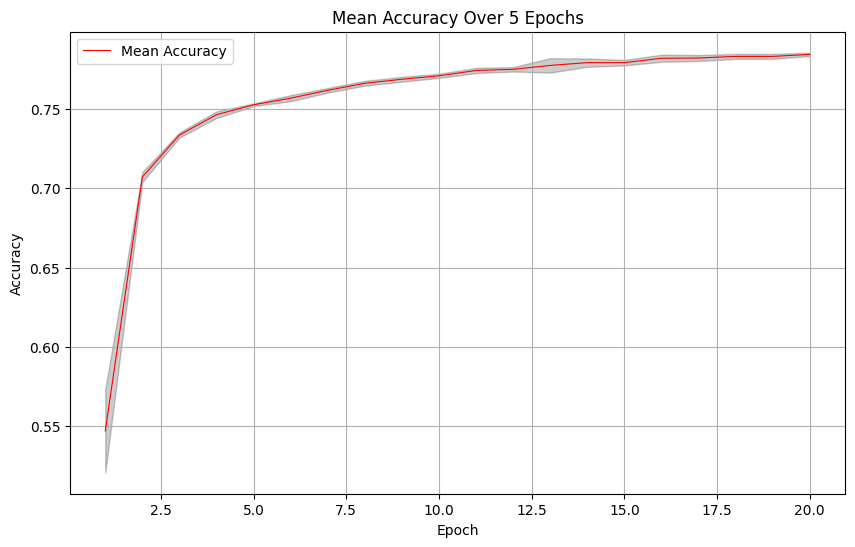

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming acc_nlarc is already defined as your accuracy data
# Calculate mean and standard deviation across runs
mean_acc = np.mean(acc_nlarc, axis=0)
std_acc = np.std(acc_nlarc, axis=0)

# Generate x-axis values starting from 1
epochs = np.arange(1, len(mean_acc) + 1)

# Plot the mean accuracy with reduced line thickness
plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_acc, label='Mean Accuracy', color='r', linewidth=0.8)  # Reduced line width

# Add error bars
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='black', alpha=0.2)

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Mean Accuracy Over 5 Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


## VGG16 on CIFAR100 dtaset

In [9]:
# Load and preprocess the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# Normalize data
x_train = x_train.astype('float64') / 255
x_test = x_test.astype('float64') / 255

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 100).astype('float64')
y_test = to_categorical(y_test, 100).astype('float64')


# callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min',
#                                                  patience=3, min_lr=0, save_best_only=True)]

metrics=['accuracy']

input_shape = (32, 32, 3)
num_classes = 100


# Conducting only one run
# Load VGG16 model, pre-trained on ImageNet without the top layer (classifier)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Assuming `base_model` is the original VGG16 loaded without top
model = Sequential()
for layer in base_model.layers:
    model.add(layer)
    if 'conv' in layer.name:
        model.add(BatchNormalization())  # Add batch normalization after each conv layer

# Continue building the rest of your model
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

# Initialize the Nlarc optimizer with specific hyperparameters
optimizer = Nlarc(learning_rate=0.1, momentum=1, global_clipnorm=1, sigma=1e-30, k0=1)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks for training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min',
                      patience=3, min_lr=1e-5, verbose=1)  # Reduce learning rate when a metric has stopped improving
]

# Train the model
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test), callbacks=callbacks)


Epoch 1/20
391/391 [==============================] - 145s 347ms/step - loss: 3.1214 - accuracy: 0.2537 - val_loss: 2.3687 - val_accuracy: 0.3851 - lr: 0.1000
Epoch 2/20
391/391 [==============================] - 135s 345ms/step - loss: 2.4752 - accuracy: 0.3640 - val_loss: 2.1452 - val_accuracy: 0.4251 - lr: 0.1000
Epoch 3/20
391/391 [==============================] - 135s 345ms/step - loss: 2.2698 - accuracy: 0.4021 - val_loss: 2.0496 - val_accuracy: 0.4510 - lr: 0.1000
Epoch 4/20
391/391 [==============================] - 135s 344ms/step - loss: 2.1589 - accuracy: 0.4251 - val_loss: 1.9902 - val_accuracy: 0.4630 - lr: 0.1000
Epoch 5/20
391/391 [==============================] - 135s 345ms/step - loss: 2.0644 - accuracy: 0.4451 - val_loss: 1.9530 - val_accuracy: 0.4738 - lr: 0.1000
Epoch 6/20
391/391 [==============================] - 135s 344ms/step - loss: 2.0123 - accuracy: 0.4566 - val_loss: 1.9078 - val_accuracy: 0.4853 - lr: 0.1000
Epoch 7/20
391/391 [==========================